# Practice With Macro Data Assignment
### Andres Perez
### Teammates: Javier Medina, Betsy Alter, Jon Scheaffer, Jacob Mackin
(4.9/5)

This is a difficult assignment, and it's okay to work in groups.  Please make one submission per group, and indicate who the team members were.

Do an analysis of the United States' business cycle that is analogous to the one we discussed in lecture.  Include three new variables: the unemployment rate  (UNRATE) , consumer durables (PCDG) , and its price index (DDURRG3Q086SBEA).  You will need to change the monthly unemployment data into a quarterly series.

These macroeconomic series do not all have the same beginning dates and ending dates.  Please make sure that you trim your data appropriately.

Make a well formatted table like that on p. 12 of Prescott's article, but include four leads and four lags for each variable. Make graphs like those I created in my lecture. 

Redo all the correlations and standard deviations, but omit the observations after 2010

In [1]:
!pip install pandas-datareader
import pandas_datareader as pdr
import pandas as pd
import datetime

# FRED Data Set

In [2]:
from fredapi import Fred
fred = Fred(api_key='6c0ecd6565503b64631fd2b36f71293a')
import statsmodels.api as sm
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,6)

In [3]:
# This will create the necessary time ranges.
start = datetime.datetime(1948, 1, 1)
end = datetime.datetime(2022, 7, 1)

# Makes Initial DataFrame
var=['GDPC1','PCECC96','GPDIC1','GCEC1','GDP','NETEXP','PCDG','DDURRG3Q086SBEA']
df_GDP = pdr.DataReader(var,'fred',start,end)

# Deflates The Nominal Series and Makes Net Exports A Share Of GDP 
df_GDP["Net_Exports"]=df_GDP["NETEXP"]/df_GDP['GDP'] 
df_GDP["Durables"]=df_GDP["PCDG"]/df_GDP["DDURRG3Q086SBEA"]

# Changes Unemployment Rate To Quarterly Series 
var=['UNRATE']  
df_urate = pdr.DataReader(var,'fred',start,end).resample('Q').first()/100

# Resets Index 
index = df_GDP.index
df_urate.index=index

# Add Unemployment Rate to Initial DataFrame
df_GDP["Unemployment"]=df_urate['UNRATE'] #put it into the bigger data frame

# Rename Columns and Drops Unnecessary Columns 
df_GDP.rename(columns={"GDPC1": "Real_GDP", "PCECC96": "Consumption", "GPDIC1": "Investment","GCEC1": "Government_Spending"}, inplace = True)
df_GDP.drop(columns=['GDP', 'NETEXP','PCDG','DDURRG3Q086SBEA'],inplace = True)
df_GDP

,Real_GDP,Consumption,Investment,Government_Spending,Net_Exports,Durables,Unemployment
DATE,,,,,,,
1948-01-01,2087.442,1309.834,257.220,526.970,0.027444,0.488831,0.034
1948-04-01,2121.899,1325.075,273.138,545.557,0.019096,0.492162,0.039
1948-07-01,2134.056,1327.031,275.936,556.940,0.017726,0.500525,0.036
1948-10-01,2136.440,1337.622,262.741,577.453,0.016054,0.493576,0.037
1949-01-01,2107.001,1339.787,223.507,592.769,0.023553,0.484630,0.043
...,...,...,...,...,...,...,...
2021-07-01,19672.594,13874.396,3584.050,3421.046,-0.037755,22.071965,0.054
2021-10-01,20006.181,13981.514,3841.771,3412.858,-0.037566,22.350360,0.045
2022-01-01,19924.088,14028.383,3892.480,3393.389,-0.045136,22.766091,0.040


# Understanding The Business Cycle: Auto/Cross-Correlations

In [4]:
# The Hodrick Prescott Filter
Y_cycle, Y_trend = sm.tsa.filters.hpfilter(np.log(df_GDP.Real_GDP), 1600)
C_cycle, C_trend = sm.tsa.filters.hpfilter(np.log(df_GDP.Consumption), 1600)
I_cycle, I_trend = sm.tsa.filters.hpfilter(np.log(df_GDP.Investment), 1600)
G_cycle, G_trend = sm.tsa.filters.hpfilter(np.log(df_GDP.Government_Spending), 1600)
X_cycle, X_trend = sm.tsa.filters.hpfilter(df_GDP.Net_Exports, 1600)
D_cycle, D_trend = sm.tsa.filters.hpfilter(np.log(df_GDP.Durables), 1600)
U_cycle, U_trend = sm.tsa.filters.hpfilter(df_GDP.Unemployment, 1600)

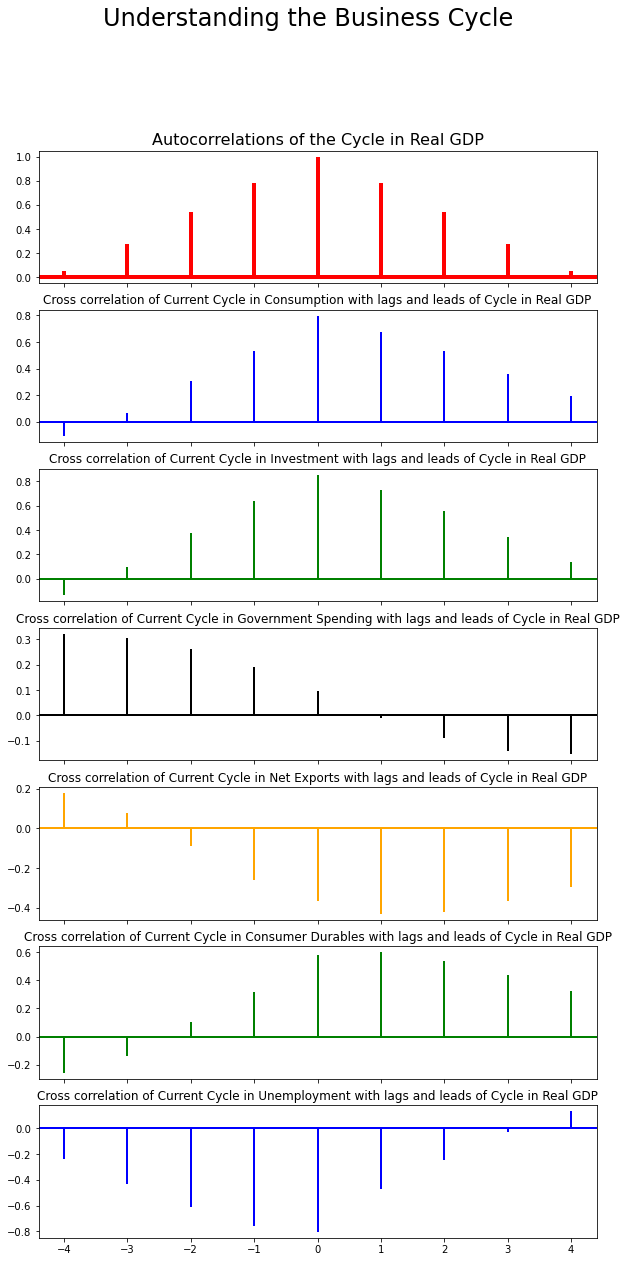

In [5]:
#Plot 

plt.rcParams['figure.figsize'] = (10,20)

fig, [ax1, ax2, ax3, ax4, ax5, ax6, ax7] = plt.subplots(7, 1, sharex=True)
fig.suptitle('Understanding the Business Cycle', fontsize=24)

#Y
ax1.set_title('Autocorrelations of the Cycle in Real GDP',fontsize=16)
ax1.acorr(Y_cycle, usevlines=True, normed=True, maxlags=4, lw=4, color = 'r')

# C
ax2.set_title('Cross correlation of Current Cycle in Consumption with lags and leads of Cycle in Real GDP')
ax2.xcorr(Y_cycle, C_cycle, usevlines=True, maxlags=4, normed=True, lw=2, color = 'b')

# I
ax3.set_title('Cross correlation of Current Cycle in Investment with lags and leads of Cycle in Real GDP')
ax3.xcorr(Y_cycle, I_cycle, usevlines=True, maxlags=4, normed=True, lw=2, color ='g')

# G
ax4.set_title('Cross correlation of Current Cycle in Government Spending with lags and leads of Cycle in Real GDP')
ax4.xcorr(Y_cycle, G_cycle, usevlines=True, maxlags=4, normed=True, lw=2, color='black')

# Net Exports
ax5.set_title('Cross correlation of Current Cycle in Net Exports with lags and leads of Cycle in Real GDP')
ax5.xcorr(Y_cycle, X_cycle, usevlines=True, maxlags=4, normed=True, lw=2, color = 'orange')

# Durables
ax6.set_title('Cross correlation of Current Cycle in Consumer Durables with lags and leads of Cycle in Real GDP')
ax6.xcorr(Y_cycle, D_cycle, usevlines=True, maxlags=4, normed=True, lw=2, color = 'green')

# Urate
ax7.set_title('Cross correlation of Current Cycle in Unemployment with lags and leads of Cycle in Real GDP')
ax7.xcorr(Y_cycle, U_cycle, usevlines=True, maxlags=4, normed=True, lw=2, color = 'blue')

plt.show()

# Table 1: Standard Deviations and Cross Correlations (Full Sample)

In [6]:
# Table Formatting
def color_negative_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = 'red' if val < 0 else 'black'
    return 'color: %s' % color

def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

In [7]:
# Cross Correlation Function 
def cor(x,y,xlag):
    """
    This function computs cross correlations with leads and lags of x only
    I regret to say that I had to write this function to do the homework.
    It is essentially a bunch of code that carefully trims the data.
    """
    m=len(x) 
    n=len(y)
    if not isinstance(xlag,int):  #check that we are using integers for lags or leads of x
        return('The lag length is not an integer.')
    if m != n: #check that the series match
        return('The series do not have the same length.')
    
    if xlag==0: #special case with no trimming
        x1 = x
        y1 = y
        # The next statement is the defintion of correlation
        return np.corrcoef(x1,y1)[0,1] #upper right element of the correlation matrix
   
    if xlag > 0:
        x1 = x[:-xlag] #trim off the end
        y1 = y[xlag:]  #trim off the beginning
        return np.corrcoef(x1,y1)[0,1]
    
    if xlag < 0:
        x1 = x[-xlag:] #trim off the beginning
        y1 = y[:xlag]  #trim off the end
        return np.corrcoef(x1,y1)[0,1]
    
    #check if my code is really out to lunch
    return('Nothing happened')

In [8]:
# Standard Deviations
names = [Y_cycle, C_cycle, I_cycle, G_cycle, X_cycle, D_cycle, U_cycle]
stdev = [np.std(macrovar)for macrovar in names] 

# Correlations
z = [4,3,2,1,0,-1,-2,-3,-4]
y=[]
for xlags in z:
    y.append([cor(Y_cycle, macrovar, xlags)for macrovar in names])

In [9]:
# Dictionary
data = {'SD':  stdev, 'Y(-4)': y[0], 'Y(-3)': y[1], 'Y(-2)': y[2], 'Y(-1)': y[3], 'Y(0)': y[4],
        'Y(+1)': y[5], 'Y(+2)': y[6], 'Y(+3)': y[7], 'Y(+4)': y[8]}      
# Column Names
df = pd.DataFrame (data, columns = ['SD','Y(-4)','Y(-3)','Y(-2)','Y(-1)','Y(0)','Y(+1)','Y(+2)','Y(+3)','Y(+4)'])
                                
# Row Names
names = ['Real_GDP','Consumption','Investment','Government_Spending','Net_Exports', 'Durables','Unemployment']
df.index = names
# Prescott Table
df.index.name = 'Macro Variable'

df = pd.concat([df.filter(items=['SD']), 
                   df.filter(items = ['Y(-4)','Y(-3)', 'Y(-2)', 'Y(-1)', 'Y(0)','Y(+1)', 'Y(+2)', 'Y(+3)', 'Y(+4)'])], 
                  axis = 1, keys = ('', 'Cross Correlation of Real GDP With'))

# Data Frame Format
df.style.format(precision=3)\
  .applymap(color_negative_red)\
  .apply(highlight_max)

# Table 2: Standard Deviations & Cross-Correlations (Pre-2010)

In [10]:
# Removes Necessary Observations
trim=47
df_GDP1=df_GDP[:-trim]

In [11]:
# The Hodrick Prescott Filter
Y_cycle1, Y_trend1 = sm.tsa.filters.hpfilter(np.log(df_GDP1.Real_GDP), 1600)
C_cycle1, C_trend1 = sm.tsa.filters.hpfilter(np.log(df_GDP1.Consumption), 1600)
I_cycle1, I_trend1 = sm.tsa.filters.hpfilter(np.log(df_GDP1.Investment), 1600)
G_cycle1, G_trend1 = sm.tsa.filters.hpfilter(np.log(df_GDP1.Government_Spending), 1600)
X_cycle1, X_trend1 = sm.tsa.filters.hpfilter(df_GDP1.Net_Exports, 1600)
D_cycle1, D_trend1 = sm.tsa.filters.hpfilter(np.log(df_GDP1.Durables), 1600)
U_cycle1, U_trend1 = sm.tsa.filters.hpfilter(df_GDP1.Unemployment, 1600)

In [12]:
# Standard Deviations
names = [Y_cycle1, C_cycle1, I_cycle1, G_cycle1, X_cycle1, D_cycle1, U_cycle1]
stdev = [np.std(macrovar)for macrovar in names] 

# Correlations
z = [4,3,2,1,0,-1,-2,-3,-4]
y=[]
for xlags in z:
    y.append([cor(Y_cycle1, macrovar, xlags)for macrovar in names])

In [13]:
# Dictionary
data = {'SD':  stdev, 'Y(-4)': y[0], 'Y(-3)': y[1], 'Y(-2)': y[2], 'Y(-1)': y[3], 'Y(0)': y[4],
        'Y(+1)': y[5], 'Y(+2)': y[6], 'Y(+3)': y[7], 'Y(+4)': y[8]}
        
# Column Names
df2 = pd.DataFrame (data, columns = ['SD','Y(-4)','Y(-3)','Y(-2)','Y(-1)','Y(0)','Y(+1)','Y(+2)','Y(+3)','Y(+4)'])
                                
# Row Names
names = ['Real_GDP','Consumption','Investment','Government_Spending','Net_Exports', 'Durables','Unemployment']
df2.index = names
# Prescott Table
df2.index.name = 'Macro Variable'

# Table Title
df2 = pd.concat([df2.filter(items=['SD']), 
                   df2.filter(items = ['Y(-4)','Y(-3)', 'Y(-2)', 'Y(-1)', 'Y(0)','Y(+1)', 'Y(+2)', 'Y(+3)', 'Y(+4)'])], 
                  axis = 1, keys = ('', 'Cross Correlation of Real GDP With'))

# Data Frame Format
df2.style.format(precision=3)\
  .applymap(color_negative_red)\
  .apply(highlight_max)

# Table 3: Absolute Values Of The Differences

In [14]:
Difference = abs(df - df2)
Difference.style.format(precision=3)

# Table 4: Maximum By Macro Variable

In [15]:
np.max(Difference.T)

D:\Applications\Python\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


Macro Variable
Real_GDP               0.068011
Consumption            0.098653
Investment             0.045010
Government_Spending    0.060390
Net_Exports            0.028882
Durables               0.077249
Unemployment           0.213611
dtype: float64

# Conclusion

Under the assumption that the cycle in Real GDP is the driver of all activity, we found that investment is the most volatile component in both the full sample $(0.072)$ and the pre-2010 sample $(0.075)$, followed by consumer durables $(0.048/0.050)$ 

Under the assumption that the cycle in Real GDP is the driver of all activity, we found that investment is the most volatile component in both the full sample $(0.072)$ and the pre-2010 sample $(0.075)$, followed by consumer durables $(0.048/0.050)$. 
By analyzing the United States' business cycle with a variety of variables, such as unemplotment rate and durables, we were able to better understand and illustrate how the business cycle looks like and how it affects human behavior depending on predictions. Another major take away from this assigment was the understanding of lags and leads which help businesses asses their current state and predict future conditions to better prepare for the future. We also graphed and analized the crosscorrelation between all of our current cycle variables and lags/leads of real GDP.  
